# Nail Disease Classifier V1

In [115]:
import torch, torchvision, torchmetrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Data Preparation

In [116]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [117]:
from pathlib import Path
from torchvision import datasets, transforms as T


DATA_DIR = Path("data/")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"
VALID_DIR = DATA_DIR / "valid"

RANDOM_SEED = 0

In [118]:
# Plotting random images
import random
from PIL import Image

def plot_images(data_dir: Path,
                transforms: T=None,
                random_seed: int=None):
    random.seed(random_seed)

    image_path_list = list(data_dir.glob("*/*/*.jpg"))
    fig = plt.figure(figsize=(10,7))
    rows, cols = 3, 3

    for i in range(1, rows * cols + 1):
        random_img_path = random.choice(image_path_list)
        img_class = random_img_path.parent.stem
        fig.add_subplot(rows, cols, i)
        random_img = Image.open(random_img_path)

        if transforms:
            transformed_img = transforms(random_img)
            plt.imshow(transformed_img.permute(1, 2, 0))
        else:
            plt.imshow(random_img)
        plt.title(f"{img_class} ({random_img.height}, {random_img.width})")
        plt.axis(False)
    

### Raw images

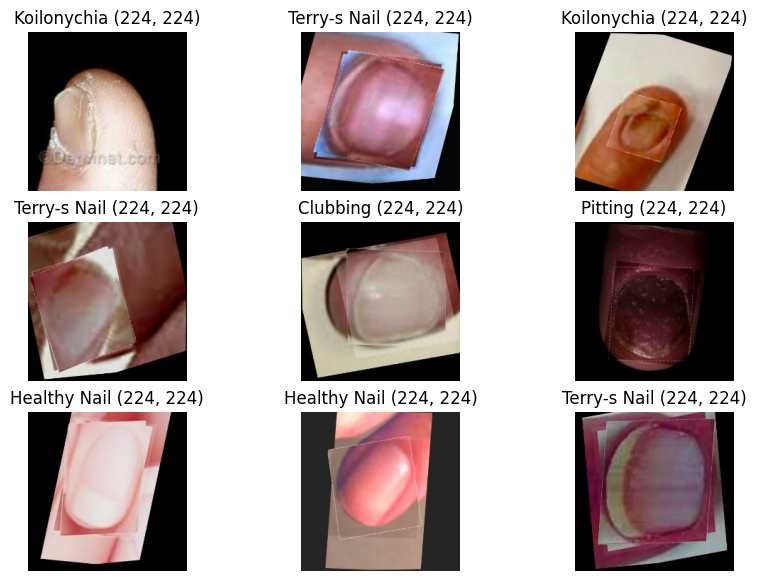

In [119]:
plot_images(data_dir=DATA_DIR, random_seed=RANDOM_SEED)

### Transforms

In [120]:
transform = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(), 
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

### Transformed Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8158263].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5125438].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083

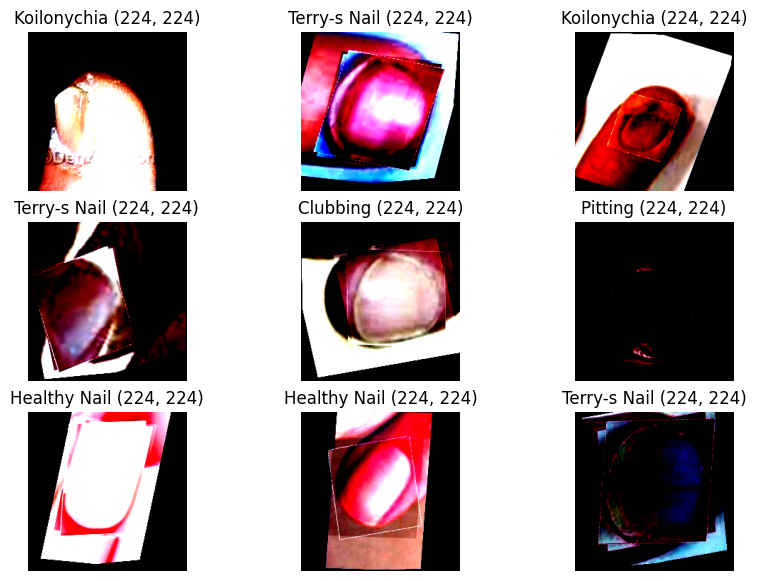

In [121]:
plot_images(data_dir=DATA_DIR, transforms=transform, random_seed=RANDOM_SEED)

In [122]:
train_data = datasets.ImageFolder(root=TRAIN_DIR,
                                  transform=transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=TEST_DIR,
                                  transform=transform,
                                  target_transform=None)

valid_data = datasets.ImageFolder(root=VALID_DIR,
                                  transform=transform,
                                  target_transform=None)

class_names = train_data.classes

print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")
print(f"Valid data length: {len(valid_data)}")
print(f"Number of Classes: {len(class_names)}")
print(f"Class Names: \n{class_names}")

Train data length: 6360
Test data length: 307
Valid data length: 591
Number of Classes: 10
Class Names: 
['Acral Lentiginous Melanoma', 'Beaus Line', 'Blue Finger', 'Clubbing', 'Healthy Nail', 'Koilonychia', 'Muehrckes Lines', 'Onychogryphosis', 'Pitting', 'Terry-s Nail']


### Data Loader 

In [123]:
from torch.utils.data import DataLoader

torch.manual_seed(0)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

valid_dataloader = DataLoader(dataset=valid_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

print(f"Train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Valid dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")

Train dataloader: 199 batches of 32
Test dataloader: 10 batches of 32
Valid dataloader: 19 batches of 32


In [124]:
img, label = next(iter(train_dataloader))

img.shape, label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Model Building

In [125]:
import torchvision.models as models
from torchmetrics import Accuracy
from torch import nn

vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Change VGG16 to output 10 classes
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=len(class_names))
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(params=vgg16.parameters(),
                            lr=0.01)
accuracy_fn = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

In [126]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs training with model trying to learn on `data_loader`"""

    train_loss, train_acc = 0, 0

    model.train()
    for batch, (X_train, y_train) in enumerate(data_loader):

        # Put data on target device
        X_train, y_train = X_train.to(device), y_train.to(device)
  
        # Forward pass (outputs the raw logits from the model)
        y_pred = model(X_train)

        loss = criterion(y_pred, y_train)
        train_loss += loss
        train_acc += accuracy_fn(y_train, y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

In [127]:
def valid_step(model: torch.nn.Module,
                    data_loader: torch.utils.data.DataLoader,
                    criterion: torch.nn.Module,
                    accuracy_fn,
                    device: torch.device):
    """Performs validation with model trying to learn on `data_loader`"""

    valid_loss, valid_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X_valid, y_valid in data_loader:
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            
            valid_pred = model(X_valid)

            valid_loss += criterion(valid_pred, y_valid)
            valid_acc += accuracy_fn(y_valid, valid_pred.argmax(dim=1))

        valid_loss /= len(data_loader)
        valid_acc /= len(data_loader)
    return valid_loss, valid_acc

In [128]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

def train_model(epochs: int,
          model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader,
          criterion: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy_fn,
          device: torch.device=device):

    # Create  empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    start_time = timer()
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, criterion, optimizer, accuracy_fn, device)
        test_loss, test_acc = valid_step(model, valid_dataloader, criterion, accuracy_fn, device)

        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f}, Train accuracy : {train_acc:.4f} | Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        # Update results dictionary
        results["train_loss"].append(train_loss.item())
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss.item())
        results["test_acc"].append(test_acc)

    end_time = timer()
    training_time = end_time - start_time

    print(f"Total time on {device}: {training_time:.3f}")

    return results

## Training the Model

In [ ]:
EPOCHS = 5

vgg16_results = train_model(epochs=EPOCHS,
                            model=vgg16,
                            train_dataloader=train_dataloader,
                            valid_dataloader=valid_dataloader,
                            criterion=criterion,
                            optimizer=optimizer,
                            accuracy_fn=accuracy_fn,
                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]